In [1]:
#set up by importing libraries

import numpy as np
import scipy.optimize as op
import matplotlib.pylab as plt
%matplotlib inline

import os
import shutil
import cPickle as cpkl
import csv
import emcee
import scipy as sp
from scipy import stats
import sys

In [2]:
# setup object contains inputs of necessary parameters for code, copied from my old code

class setup(object):
    """
    setup object specifies all parameters controlling one run of p(z) inference program
    """
    def __init__(self,input_address='hogg'):

        self.inadd = input_address
        self.testdir = os.path.join('..','tests')
        self.datadir = os.path.join(self.testdir,input_address)

        self.name = 'Hogg\'s Test'

        # take in specification of bins if provided, otherwise make some

        self.allnbins = 35
        binstep = 1. / self.allnbins
        self.allzs = np.arange(0.,1.+binstep,binstep)

        # his, los, centers of bins and bin widths handy for plotting
        self.allzlos = self.allzs[:-1]
        self.allzhis = self.allzs[1:]
        self.allzmids = (self.allzhis + self.allzlos) / 2
        self.zdifs = self.allzhis - self.allzlos
        self.zdif = sum(self.zdifs) / self.allnbins

        # define a physical P(z)
        # for sum of Gaussians, elements of the form (z_center, spread, magnitude)
        # take in specification of underlying P(z) if provided, otherwise make one
        self.zrange = max(self.allzs)-min(self.allzs)
        self.zmin = min(self.allzs)
        self.zmax = max(self.allzs)
        
        self.real = np.array([[self.zmin+0.2*self.zrange, 0.08, 0.3],
                         [self.zmin+0.4*self.zrange, 0.06, 0.4],
                         [self.zmin+0.6*self.zrange, 0.06, 0.2],
                         [self.zmin+0.8*self.zrange, 0.1, 0.1]
                          ])

        self.surv = 1e4
#         self.poisson = bool(1)
#         self.random = bool(1)
#         self.interim = 'flat'#corresponding to 'flat','unimodal','bimodal','multimodal'#bool(0)
#         self.sigma = bool(0)
        self.noisefact = 2
#         self.shape = 1
#         self.outlier = 0
        self.degen = 1
#         self.noise = bool(0)

        # colors for plots
#         self.colors='brgycm'

        self.topdir = os.path.join(self.testdir,self.inadd)
        if os.path.exists(self.topdir):
            shutil.rmtree(self.topdir)
        os.makedirs(self.topdir)

        self.simdir = os.path.join(self.topdir,'data')
        if os.path.exists(self.simdir):
            shutil.rmtree(self.simdir)
        os.makedirs(self.simdir)
        
        self.mcmcdir = os.path.join(self.datadir,'mcmc')
        if os.path.exists(self.mcmcdir):
            shutil.rmtree(self.mcmcdir)
        os.makedirs(self.mcmcdir)

        print(self.name+' ingested inputs')
        
meta = setup()

Hogg's Test ingested inputs


In [3]:
#define a gaussian so as not to rely on numpy/scipy definitions

class gauss(object):
    
    def __init__(self,mean,sigma,amp=1.):
        self.epsilon = sys.float_info.min
        self.mean = mean
        self.sigma = sigma
        self.amp = amp
        
    def evaluate_one(self,z):
        p = 0.
        if z>0. and z<1.:
            p = self.amp / (np.sqrt(2. * np.pi) * self.sigma) * \
                np.exp(-0.5 * (z - self.mean) ** 2 / self.sigma ** 2)
        return p
        
    def evaluate(self,zs):
        #print('zs of type '+str(type(zs))+' in gauss')
        if type(zs) != np.ndarray:
            ps = self.evaluate_one(zs)#np.array([self.evaluate_one(zs)])
        else:
            ps = np.zeros_like(zs)
        #print(zs)
            for n,z in enumerate(zs):
            #print(n,z)
                ps[n] += self.evaluate_one(z)#+= self.amp / (np.sqrt(2. * np.pi) * self.sigma) * \
                                #np.exp(-0.5 * (z - self.mean) ** 2 / self.sigma ** 2)
        ps[zs < 0.] = self.epsilon
        ps[zs > 1.] = self.epsilon
        #print(len(ps))
        return ps

In [4]:
#define normalized gaussian mixture

class gmix(object):
    
    def __init__(self,means,sigmas,amps=np.ones(1)):
        self.epsilon = sys.float_info.min
        self.means = means
        self.sigmas = sigmas
        self.amps = amps
        self.amps /= np.sum(self.amps)
        self.cumamps = np.cumsum(self.amps)
        
    def sample(self):
        z = -1.#z=z_true here
        while z < 0. or z > 1.:
            r = np.random.uniform(0., self.cumamps[-1])
            c = 0
            for k in range(1, len(self.cumamps)):
                if r > self.cumamps[k-1]:
                    c = k
            z = self.means[c] + self.sigmas[c] * np.random.normal()
        return z
    
    def evaluate(self,zs):
        """
        Back to non-normalized function#Now returns properly normalized function
        """
        #dz = np.average(zs[1:]-zs[:-1])
        #print('zs of type '+str(type(zs))+' in gmix')
        if len(zs) == 1:
            ps = 0.
        else:
            ps = np.zeros_like(zs)
        for c in range(len(self.amps)):
            dist = gauss(self.means[c],self.sigmas[c],self.amps[c])
            ps += dist.evaluate(zs)#self.amps[c] * / (np.sqrt(2. * np.pi) * self.sigmas[c]) * \
                #np.exp(-0.5 * (zs - self.means[c]) ** 2 / self.sigmas[c] ** 2)
        ps[zs < 0.] = self.epsilon
        ps[zs > 1.] = self.epsilon
        #ps = ps/np.sum(ps*dz)
        return ps

In [5]:
#set up truth

np.random.seed(meta.allnbins)#42)
N = int(meta.surv)#2 ** 16

truemeans = np.array([0.5, 0.2, 0.75])#meta.real.T[0]#np.array([0.5, 0.2, 0.75])
truesigmas = np.array([0.4, 0.2, 0.1])#meta.real.T[1]#np.array([0.4, 0.2, 0.1])
trueamps = np.array([0.20, 0.35, 0.55])#meta.real.T[2]#np.array([0.20, 0.35, 0.55])

meta.real = np.array([truemeans,truesigmas,trueamps]).T
with open(os.path.join(meta.simdir,'truth.p'),'wb') as cpfile:
    cpkl.dump(meta.real, cpfile)
    
truedist = gmix(truemeans,truesigmas,trueamps)
trueamps = truedist.amps#/= np.sum(trueamps)
cumamps = truedist.cumamps#np.cumsum(trueamps)

In [6]:
#function to sample the truth

def sample_true_prior(N):
    print("Making ztrue values...")
    ztrues = np.array([truedist.sample() for n in range(N)])
    return ztrues

In [7]:
#making the z_true values

ztrues = sample_true_prior(N)

with open(os.path.join(meta.simdir,'logtrue.csv'),'wb') as csvfile:
    out = csv.writer(csvfile,delimiter=' ')
    truZs = [[z] for z in ztrues]
    for item in truZs:
        out.writerow(item)

nplot = meta.surv
bplot = meta.allnbins
zplot = np.arange(0.5 / nplot, 1.0, 1.0 / nplot)
dzplot = 1./nplot

Making ztrue values...


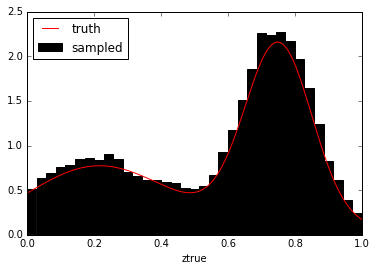

In [8]:
#plot sampling of the true distribution

plt.clf()
plt.hist(ztrues, bins=bplot, normed=True, color="k",label='sampled')
plt.plot(zplot, truedist.evaluate(zplot), "r-",label='truth')
plt.xlabel("ztrue")
plt.legend(loc='upper left')
plt.savefig(os.path.join(meta.simdir,"ztrues.png"))

In [9]:
#class for likelihood to sample in catastrophic outlier case

class likelihood(object):
    
    def __init__(self,sigma,outlier_mean=0.,outlier_sigma=1.,outlier_frac=0.):
        self.epsilon = sys.float_info.min
        self.sigma = sigma
        self.ofrac = outlier_frac
        self.omean = outlier_mean
        self.osigma = outlier_sigma
        
    def sample(self,z):#z=z_true here
        if np.random.uniform() < self.ofrac:
            mean = np.array([self.omean])
            sigma = np.array([self.osigma])
            self.dist = gmix(mean,sigma)
        else:
            mean = np.array([z])
            sigma = np.array([self.sigma])
            self.dist = gmix(mean,sigma)
        return self.dist.sample()
    
#     def evaluate(self,zobs,zs):#zs=ztrues here
#         self.odist = gauss(self.omean,self.osigma,self.ofrac)
#         self.dist = gauss(zobs,self.sigma,1.-self.ofrac)
#         if type(zs) != np.ndarray:
#             ps = 0.
#             ps += self.odist.evaluate(zobs)
#             ps += self.dist.evaluate(zobs)
#         else:
#             ps = np.zeros_like(zs)
#             ps += self.odist.evaluate(zobs)
#         #print(self.odist.evaluate(np.array(zobs)))
#         #ps += self.odist.evaluate(zobs)
#             for n,z in enumerate(zs):
#                 #print(n,z)
#             #dist = gauss(z,self.sigma,1.-self.ofrac)
#                 ps[n] += self.dist.evaluate(zobs)
#             #print(ps[n])
#             ps[zs < 0.] = 0.
#             ps[zs > 1.] = 0.
#         return ps
    def evaluate(self,zobs, zs):#zs=z_trues here
        ps = np.zeros_like(zs)
        ps += self.epsilon
        odist = gauss(self.omean,self.osigma,amp=self.ofrac)
        dist = gauss(zobs,self.sigma,amp=1.-self.ofrac)
#         ps += odist.evaluate(zs)#self.ofrac / (np.sqrt(2. * np.pi) * self.osigma) * \
#             #np.exp(-0.5 * (zobs - self.omean) ** 2 / self.osigma ** 2)
#         ps += dist.evaluate(zs)#(1. - self.ofrac) / (np.sqrt(2. * np.pi) * self.sigma) * \
#             #np.exp(-0.5 * (zobs - zs) ** 2 / self.sigma ** 2)
        ps += self.ofrac / (np.sqrt(2. * np.pi) * self.osigma) * \
              np.exp(-0.5 * (zobs - self.omean) ** 2 / self.osigma ** 2)
        ps += (1. - self.ofrac) / (np.sqrt(2. * np.pi) * self.sigma) * \
              np.exp(-0.5 * (zobs - zs) ** 2 / self.sigma ** 2)
        return ps

In [10]:
#set parameters of this test case of catastrophic outliers

true_lf_sigma = 0.05
true_lf_outlier_fraction = 0.2
true_lf_outlier_mean = 0.4
true_lf_outlier_sigma = 0.075

lf = likelihood(true_lf_sigma,
                true_lf_outlier_mean,true_lf_outlier_sigma,true_lf_outlier_fraction)

zobss = np.array([lf.sample(ztrue) for ztrue in ztrues])

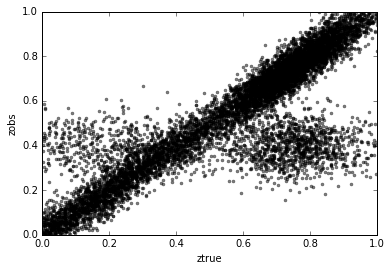

In [11]:
#plot sampling in likelihood space

plt.clf()
plt.plot(ztrues, zobss, "k.", alpha=0.5)
plt.xlabel("ztrue")
plt.ylabel("zobs")
plt.savefig(os.path.join(meta.simdir,"scatter.png"))

In [12]:
#define class for prior distribution (interim prior in my old code)

class prior(object):
    
    def __init__(self,name='flat'):
        self.epsilon = sys.float_info.min
        self.name = name
        
    def evaluate(self,zs):#zs=z_trues here
        #dzs = [np.mean(zs[1:]-zs[:-1])]*len(zs)
        if self.name == 'flat':
            #self.dz = np.mean(zs[1:]-zs[:-1])
            ps = np.ones_like(zs)#/dzs
            ps[zs < 0.] = self.epsilon
            ps[zs > 1.] = self.epsilon
        return ps
    
    def make_binned(self,grid):
        return self.evaluate(grid)

In [13]:
#define binning, for everything is discrete in this approach

K = meta.allnbins
binfactor = meta.allnbins
KK = K * binfactor # number of fine bins
interimprior = prior()

dzfine = 1. / KK
zfine = np.arange(0.5 * dzfine, 1.0, dzfine)
interimfine = interimprior.evaluate(zfine)

dzcoarse = 1. / K
zcoarse = np.arange(0.5 * dzcoarse, 1.0, dzcoarse)
interimcoarse = interimprior.evaluate(zcoarse)

print(np.sum(interimcoarse*dzcoarse))

1.0


In [14]:
#define class for posterior distribution

class posterior(object):
    def __init__(self,prior,likelihood,grid):
        self.epsilon = sys.float_info.min
        self.prior = prior
        self.likelihood = likelihood
        
        self.coarse = grid
        self.dcoarse,self.ncoarse = self.dgrid(self.coarse)
        
        self.nfine = self.ncoarse**2
        self.dfine = self.dcoarse/self.ncoarse
        self.fine = np.arange(0.5 * self.dfine, 1.0, self.dfine)
        
        self.factor = self.nfine/self.ncoarse
        
    def dgrid(self,grid):
        ngrid = len(grid)
        gridrange = grid[1:]-grid[:-1]
        dg = np.sum(gridrange)/(ngrid-1)
        return dg,ngrid

    def make_binned(self,z):#z=zobs here
        """
        stupidly slow, but only called once.
        """
        ps = self.prior.make_binned(self.fine) * self.likelihood.evaluate(z, self.fine)
        ps /= np.sum(ps) * self.dfine
        coarseps = np.array([np.sum(ps[k * self.factor : (k + 1) * self.factor]) * \
                             self.dfine for k in range(self.ncoarse)])
        return coarseps / self.dcoarse

    def make_rectangular(self,zobss):
        ps = np.zeros((len(zobss), self.ncoarse))
        ps += self.epsilon
        for n,zobs in enumerate(zobss):
            ps[n] = self.make_binned(zobs)
        return ps

In [15]:
prior_test = interimprior
lf_test = likelihood(true_lf_sigma,
                true_lf_outlier_mean,true_lf_outlier_sigma,true_lf_outlier_fraction)
post_test = posterior(interimprior,lf_test,zcoarse)

z_obs_test = zcoarse
z_tru_test = zcoarse

#joint_test = [[lf_test.evaluate(z_obs_test[n],z_tru_test[m]) 
#               for m in xrange(K)] for n in xrange(K)] 
comps_test = [[lf_test.evaluate(z_obs_test[n],z_tru_test[m])*prior_test.evaluate(z_tru_test[m])
              for m in xrange(K)] for n in xrange(K)]

#print([lf_test.evaluate(z_obs_test[n],zcoarse) for m in xrange(K)])#comps_test)

In [16]:
#create posterior distribution over binning

post = posterior(interimprior,lf,zcoarse)

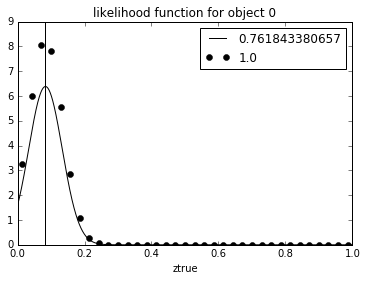

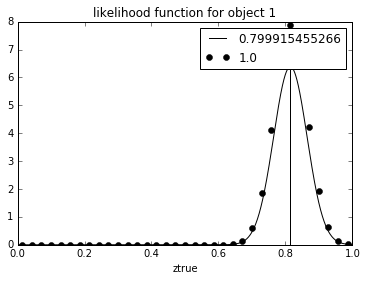

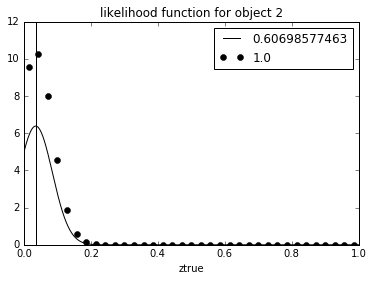

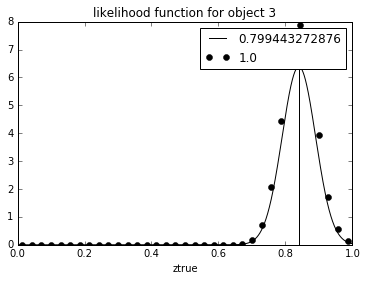

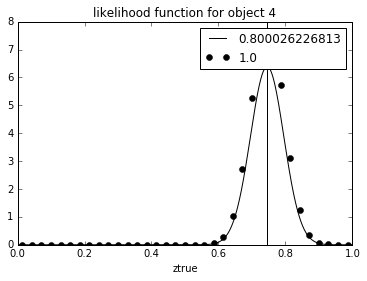

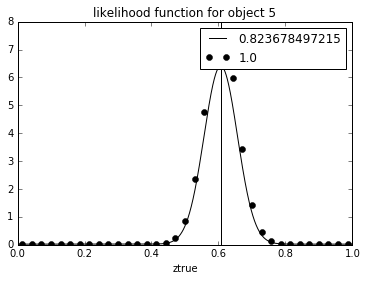

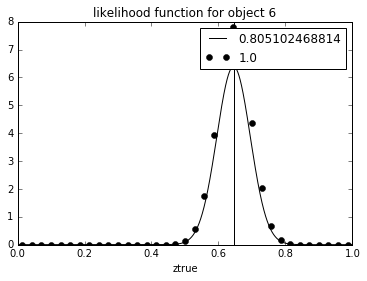

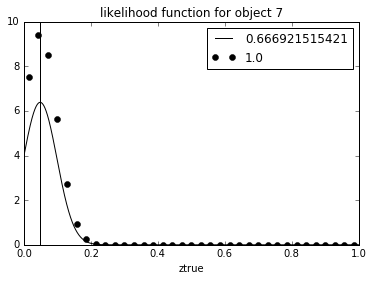

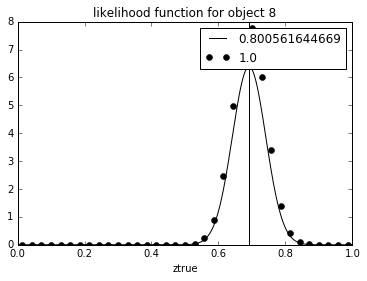

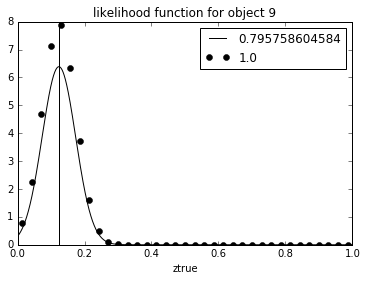

In [17]:
#plot a few examples of likelihood and posterior
#unit test that posteriors integrate to 1 (likelihoods need not integrate to 1, correct?)

for n,zobs in enumerate(zobss[:10]):
    plt.clf()
    #print(lf.evaluate([zobs], zplot))
    #print(post.make_binned(zobs))
    plt.plot(zplot, lf.evaluate(zobs, zplot), "k-", 
             label=np.sum(lf.evaluate(zobs, zplot)*dzplot))
    plt.plot(zcoarse, post.make_binned(zobs), "ko",
             label=np.sum(post.make_binned(zobs)*dzcoarse))
    plt.axvline(zobs, color="k")
    plt.xlabel("ztrue")
    plt.xlim(0., 1.)
    plt.legend()
    plt.title("likelihood function for object {}".format(n))
    plt.show()
    plt.savefig(os.path.join(meta.simdir,"lf_{:02d}.png".format(n)))

In [18]:
#slow step of making data into output format 
#and writing it to disk so it can be used by my old code

data = post.make_rectangular(zobss)

with open(os.path.join(meta.simdir,'logdata.csv'),'wb') as csvfile:
    out = csv.writer(csvfile,delimiter=' ')
    out.writerow(meta.allzs)
    out.writerow(np.log(interimcoarse))
    for line in data:
        out.writerow(np.log(line))
print('wrote data to file')

wrote data to file


1.0
1.0


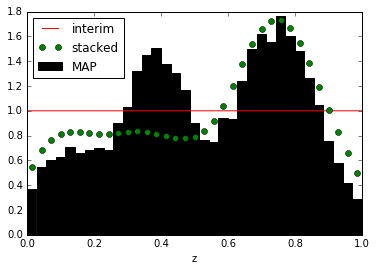

In [19]:
#plot histogram of sampled z_obs values compared to truth and interim prior

plt.clf()
plt.hist(zobss, bins=bplot, normed=True, color="k", label='MAP')
plt.plot(zplot, interimprior.evaluate(zplot), "r-",label='interim')
plt.plot(zcoarse, np.sum(data, axis=0) / N, "go",label='stacked')
plt.xlabel("z")
plt.legend(loc='upper left')
plt.savefig(os.path.join(meta.simdir,"zobs.png"))

print(np.sum(dzplot*interimprior.evaluate(zplot)))
print(np.sum(dzcoarse*np.sum(data, axis=0) / N))

In [20]:
#read data from disk so it can be used by my old code

with open(os.path.join(meta.simdir,'logdata.csv'),'rb') as csvfile:
    tuples = (line.split(None) for line in csvfile)
    alldata = [[float(pair[k]) for k in range(0,len(pair))] for pair in tuples]

meta.allzs = np.array(alldata[0])
logintNz = np.array(alldata[1])
interimcoarse = np.exp(logintNz)
logpdfs = np.array(alldata[2:])
data = np.exp(logpdfs)

print('read data from file')

read data from file


In [216]:
#define hyperprior distribution as multivariate gaussian 
#and sample to get initial values for optimization and MCMC

prior_sigma = 0.16
prior_var = np.eye(K)
for k in range(K):
    prior_var[k] = 1. * np.exp(-0.5 * (zcoarse[k] - zcoarse) ** 2 / prior_sigma ** 2)
    
# print(np.linalg.eig(prior_var))
    
# #how to marginalize over these?
# q = 1.0#controls amplitude
# e = 100.#controls number of peaks
# t = q*1.e-5#controls smoothness of curves
# prior_var = np.array([[q*np.exp(-0.5*e*(zcoarse[a]-zcoarse[b])**2.) 
#                        for a in xrange(0,meta.allnbins)] for b in xrange(0,meta.allnbins)])
# l = 1.e-4
prior_var = prior_var+l*np.identity(meta.allnbins)
    
#print(np.linalg.eig(prior_var))
#print(prior_var)
prior_ivar = np.linalg.inv(prior_var)
#print(np.shape(prior_ivar))

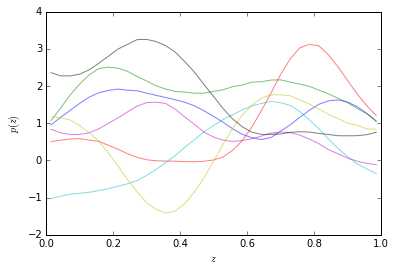

In [217]:
ivals = [np.random.multivariate_normal(interimcoarse,prior_var) 
         for i in xrange(2*meta.allnbins)]
for ival in ivals[:7]:
    plt.plot(zcoarse,ival,alpha=0.5)
    plt.ylabel(r'$p(z)$')
    plt.xlabel(r'$z$')
    plt.savefig('ivals.png')

In [183]:
#define class for hypeprior distribution
#this evaluates the posterior, prior, likelihood and optimizes

class hyperdist(object):
    
    def __init__(self,interim,data,ivar,dz):
        
        self.interim = interim
        self.data = data
        self.ivar = ivar
        self.dz = dz
        
    def optimize(self):
        def _objective(pars):
            return -2. * self.lnposterior(pars)
        guess = np.sum(self.data, axis=0)
        guess /= np.sum(guess) * self.dz
        guess = np.log(guess)
        print("starting at", guess, _objective(guess))
        res = op.minimize(_objective, guess, method="Nelder-Mead",
                          options={"maxfev": 1e5, "maxiter":1e4})
#         res = op.fmin(_objective,guess,maxiter=len(data),maxfun=len(data), disp=True)
        #print(res)
        return res
    
    def lnposterior(self,lnamps):
        out = self.lnprior(lnamps) + self.lnlf(lnamps)
        #out = np.log(np.exp(out)/np.sum(np.exp(out)*self.dz))
        #print('lnposterior='+str(out))
        return out
    
    def lnprior(self,lnamps):
        """
        Stupid Gaussian prior.
        """
        out = -0.5 * np.dot(np.dot(self.ivar, lnamps), lnamps)
        #print('lnprior='+str(out))
        return out
    
    def lnlf(self,lnamps):
        return np.sum(np.log(self.lfs(lnamps)))
    
    def lfs(self,lnamps):
        amps = np.exp(lnamps - np.max(lnamps))
        amps /= np.sum(amps)
        return np.sum(amps[None,:] * self.data / self.interim[None,:], axis=1)

('hyperposterior at interim prior:', -1.2914114222439821e-12)
('starting at', array([-0.59686357, -0.38425851, -0.26452901, -0.21001142, -0.19185832,
       -0.19127683, -0.19778133, -0.20365377, -0.20287455, -0.19452824,
       -0.18452252, -0.18149075, -0.19048363, -0.20945606, -0.23083082,
       -0.24676793, -0.25089393, -0.23363034, -0.1817819 , -0.08855158,
        0.0387693 ,  0.18207271,  0.319205  ,  0.43089037,  0.50701977,
        0.54630284,  0.54928479,  0.51384938,  0.43790691,  0.32355422,
        0.17728004,  0.0063975 , -0.18750306, -0.41488323, -0.69333942]), -1504.856417192542)


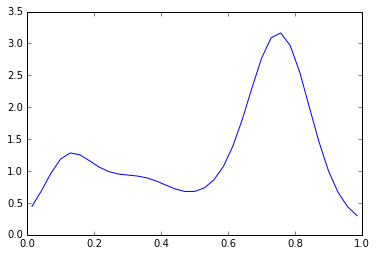

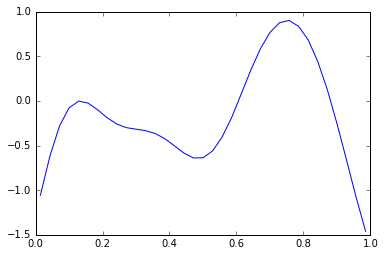

In [218]:
#execute optimization here and write out result to disk for my old code to use

hyper = hyperdist(interimcoarse,data,prior_ivar,dzcoarse)

# guess = np.log(truedist.evaluate(zcoarse))
# print("hyperposterior at truth:", hyper.lnposterior(guess))
guess = np.log(interimcoarse)
#guess = np.log(interimcoarse)
#plt.plot(zcoarse,guess)
#print('guess shape='+str(np.shape(guess))+' with guess='+str(guess))
print("hyperposterior at interim prior:", hyper.lnposterior(guess))
mml = hyper.optimize()
themap = np.exp(mml.x)
plt.plot(zcoarse,themap)
plt.show()
themap /= np.sum(themap) * dzcoarse
plt.plot(zcoarse,np.log(themap))
plt.show()

with open(os.path.join(meta.simdir,'logmmle.csv'),'wb') as csvfile:
    out = csv.writer(csvfile,delimiter=' ')
    out.writerow([mml.fun])
    out.writerow(np.log(themap))

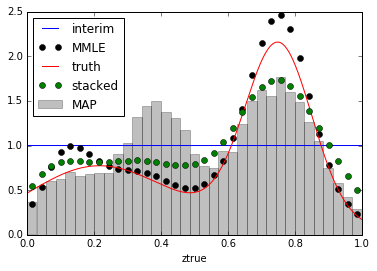

In [219]:
#plot result of optimization, histogram of z_obs values, and interim prior

plt.clf()
plt.hist(zobss, bins=bplot, normed=True, color="k", alpha=0.25,label='MAP')
plt.plot(zplot, interimprior.evaluate(zplot), "b-",label='interim')
plt.plot(zcoarse, themap, "ko",label='MMLE')
plt.plot(zplot, truedist.evaluate(zplot), "r-",label='truth')
plt.plot(zcoarse, np.sum(data, axis=0)/len(data), "go",label='stacked')
plt.xlabel("ztrue")
plt.legend(loc='upper left')
plt.savefig(os.path.join(meta.simdir,"map.png"))

In [203]:
#calculate autocorrelation times

def cft(xtimes,lag):
    """calculate autocorrelation times since emcee sometimes fails"""
    lent = len(xtimes)-lag
    allt = xrange(lent)
    ans = np.array([xtimes[t+lag]*xtimes[t] for t in allt])
    return ans

def cf(xtimes):#xtimes has ntimes elements
    cf0 = np.dot(xtimes,xtimes)
    allt = xrange(len(xtimes)/2)
    cf = np.array([sum(cft(xtimes,lag)[len(xtimes)/2:]) for lag in allt])/cf0
    return cf

def cfs(x,mode):#xbinstimes has nbins by ntimes elements
    if mode == 'walkers':
        xbinstimes = x
        cfs = np.array([sum(cf(xtimes)) for xtimes in xbinstimes])/len(xbinstimes)
    if mode == 'bins':
        xwalkerstimes = x
        cfs = np.array([sum(cf(xtimes)) for xtimes in xwalkerstimes])/len(xwalkerstimes)
    return cfs

def acors(xtimeswalkersbins,mode='bins'):
    if mode == 'walkers':
        xwalkersbinstimes = np.swapaxes(xtimeswalkersbins,1,2)#nwalkers by nbins by nsteps
        taus = np.array([1. + 2.*sum(cfs(xbinstimes,mode)) for xbinstimes
                         in xwalkersbinstimes])
    if mode == 'bins':
        xbinswalkerstimes = xtimeswalkersbins.T#nbins by nwalkers by nsteps
        taus = np.array([1. + 2.*sum(cfs(xwalkerstimes,mode)) for xwalkerstimes
                         in xbinswalkerstimes])
    return taus

In [ ]:
def single_parameter_gr_test(chain):
    ssq = np.var(chain, axis=1, ddof=1)
    W = np.mean(ssq, axis=0)
    xb = np.mean(chain, axis=1)
    xbb = np.mean(xb, axis=0)
    m = chain.shape[0]
    n = chain.shape[1]
    B = n / (m - 1.) * np.sum((xbb - xb)**2., axis=0)
    var_x = (n - 1.) / n * W + 1. / n * B
    Rhat = np.sqrt(var_x / W)
    return Rhat,var_x

def gr_test(sample , dims):
    """
    inputs:
      sample = an emcee sample
      nwalkers = number of walkers
    returns:
      Rs = npar-dimensional vector of the
      potential scale reduction factors
      Vs = npar-dimensional vector of the
      variances
    """
    #npar = len(sample[0])
    #niters = len(sample)
    (nwalkers,niters,npars) = dims
    nburnins = niters/2
    chain_ensemble = sample.reshape(niters , nwalkers , npars)
    chain_ensemble = chain_ensemble[nburnins: , :]
    Rs = np.zeros((npars))
    Vs = np.zeros((npars))
    for i in range(npars):
        chains = chain_ensemble[ : , : , i].T
        output = single_parameter_gr_test(chains)
        Rs[i] = output[0]
        Vs[i] = output[1]
    return Rs , Vs

def burntest(outputs):# of dimensions nwalkers*miniters
    """Gelman-Rubin test whether burning in or done with that, true if burning in"""
    print('testing burn-in condition')
    #gelman-rubin condition
    chains = outputs['chains']#nwalkers*nsteps*nbins
    dims = np.shape(chains)
    gr = gr_test(chains, dims)[0]
    critical = 1.1
#     if np.max(gr) > critical:
#         print(run.meta.name+' burning-in '+str(gr)+' > '+str(critical))
#     else:
#         print(run.meta.name+' post-burn '+str(gr)+' < '+str(critical))
    return(np.max(gr) > critical)

#check me!
# def sampling:
#     while burntest(outputs,self):
#         yield self
#         self.burns += 1
#         self.runs += 1
#         outputs = self.preburn(self.runs)
#     else:
#         self.atburn(self.runs, outputs)
#         while self.runs <= self.nsteps:
#             yield self
#             self.runs += 1
#             self.postburn(self.runs)
#     return

In [117]:
#MCMC to possibly replace optimization?

def emcee_dist(params,hyperdistro):
    return hyperdistro.lnposterior(params)

nwalkers = 2*meta.allnbins
sampler = emcee.EnsembleSampler(nwalkers, meta.allnbins, emcee_dist, args=[hyper])
#print(np.shape(themap))
#print(np.shape(prior_sigma*np.identity(meta.allnbins)))
# guess = np.sum(data, axis=0)
# guess /= np.sum(guess) * dzcoarse
# guess = np.log(guess)
guess = interimcoarse
ivals = [np.random.multivariate_normal(guess,prior_var) 
         for i in xrange(nwalkers)]
# ivals = [np.random.multivariate_normal(np.log(themap),prior_sigma*np.identity(meta.allnbins)) 
#          for b in xrange(nwalkers)]

miniters = 1000
allchains = []
vals = ivals
for x in xrange(5):
    sampler.reset()
    vals,prob,state = sampler.run_mcmc(vals, miniters,thin=10)
    allchains.append(sampler.chain)
    print('sampled '+str((x+1)*miniters)+' with '+str(np.mean(acors(sampler.chain)))\
          +' autocorrelation time')
allchains = np.array(allchains)
print('done sampling!')

sampled 1000 with 16.8323437969 autocorrelation time
sampled 2000 with 14.7381293116 autocorrelation time
sampled 3000 with 11.8384505525 autocorrelation time
sampled 4000 with 11.8068153413 autocorrelation time
sampled 5000 with 11.6429370237 autocorrelation time
done sampling!


In [118]:
#define confidence regions for sampler output

import hickle as hkl

allchains = np.array(allchains)
allsamples = os.path.join(meta.mcmcdir, 'samples.hkl')
hkl.dump(allchains,allsamples)
# with open(allsamples,'wb') as csvfile:
#     out = csv.writer(csvfile,delimiter=' ')
#     out.writerow(zcoarse)
#     for line in allchains:
#         out.writerow(line)

allchains_loaded = hkl.load(allsamples)
# with open(allsamples,'rb') as csvfile:
#     tuples = (line.split(None) for line in csvfile)
#     alldata = [[float(pair[k]) for k in range(0,len(pair))] for pair in tuples][1:]
#     nbins = len(alldata[0])
#     alldata = np.array(alldata).T

#chains = sampler.chain
print(np.shape(allchains_loaded.T))
locs,scales = [],[]
for k in xrange(meta.allnbins):
    y_all = allchains.T[k].flatten()
    loc,scale = sp.stats.norm.fit_loc_scale(y_all)
    locs.append(loc)
    scales.append(scale)
locs = np.array(locs)
locs = np.log(np.exp(locs)/np.sum(np.exp(locs)*dzcoarse))
scales = np.array(scales)
print(locs,scales)

x_cors,y_cors = [],[]
for k in xrange(meta.allnbins):
    x_cor = [meta.allzs[k],meta.allzs[k],meta.allzs[k+1],meta.allzs[k+1]]
    y_cor = np.array([locs[k]-scales[k],locs[k]+scales[k],locs[k]+scales[k],locs[k]-scales[k]])
    x_cors.append(x_cor)
    y_cors.append(y_cor)
x_cors = np.array(x_cors)
y_cors = np.array(y_cors)

dumping <type 'numpy.ndarray'> to file <HDF5 file "samples.hkl" (mode r+)>
(35, 100, 70, 5)
(array([-2.72520031, -1.43400553,  0.0449012 ,  0.50153481, -0.03404441,
       -0.54905308, -0.50648147, -0.26794647, -0.19872106, -0.2044288 ,
       -0.17273285, -0.22926168, -0.43252901, -0.66895503, -0.80778953,
       -0.81178047, -0.74946868, -0.67875647, -0.56425811, -0.39563088,
       -0.1580335 ,  0.16914263,  0.51785549,  0.70400491,  0.72521359,
        0.80769233,  0.91119061,  0.81329468,  0.52617077,  0.33600889,
        0.41303726,  0.33899511, -0.56432032, -2.0625662 , -2.96466669]), array([ 0.89548521,  0.68651884,  0.42628568,  0.38118366,  0.45994182,
        0.56017483,  0.54335329,  0.46120968,  0.44290977,  0.48095094,
        0.50411078,  0.46877758,  0.47488748,  0.53545905,  0.61960162,
        0.60832477,  0.51948853,  0.47171029,  0.47450569,  0.51876734,
        0.51412239,  0.46998403,  0.42896343,  0.43936838,  0.47718147,
        0.47830879,  0.41855937,  0.40499

In [119]:
def calckl(difs,lqn,lpn):
    """KL Divergence test"""
    pn = np.exp(lpn)*difs
    qn = np.exp(lqn)*difs
    p = pn/np.sum(pn)
    q = qn/np.sum(qn)
    logp = um.safelog(p)
    logq = um.safelog(q)
    klpq = np.sum(p*(logp-logq))
    klqp = np.sum(q*(logq-logp))
    return(klpq,klqp)

0.908143061786
1.0
1.0


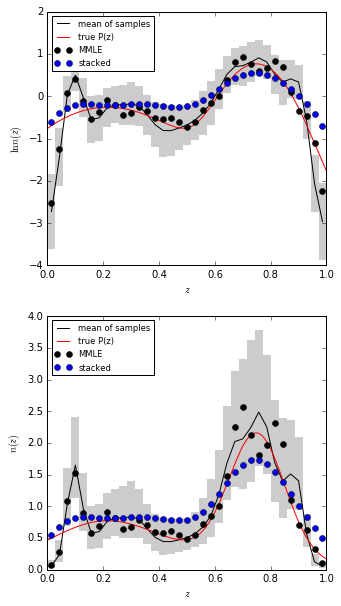

In [120]:
#plot result of MCMC in log space

f = plt.figure(figsize=(5,10))
sps = [f.add_subplot(2,1,l+1) for l in xrange(0,2)]

sps[0].plot(zcoarse,locs,c='k',label='mean of samples')
for k in xrange(meta.allnbins):
#    sps[0].fill(x_cors[k],y_cors2[k],color='k',alpha=0.1,linewidth=0.)
    sps[0].fill(x_cors[k],y_cors[k],color='k',alpha=0.2,linewidth=0.)
#plt.hist(ztrues, bins=bplot, normed=True, color="r",alpha=0.25,label='true N(z)')
sps[0].plot(zplot, np.log(truedist.evaluate(zplot)), "r-",label='true P(z)')
#plt.hist(zobss, bins=bplot, normed=True, color="b", alpha=0.25,label='MAP')
#plt.plot(zplot, interimprior.evaluate(zplot), "g-",label='interim prior')
sps[0].plot(zcoarse, np.log(themap), "ko",label='MMLE')
sps[0].plot(zcoarse, np.log(np.sum(data, axis=0) / N), "bo",label='stacked')
sps[0].set_ylabel(r'$\ln n(z)$')
sps[0].set_xlabel(r'$z$')
sps[0].legend(loc='upper left',fontsize='small')

sps[1].plot(zcoarse,np.exp(locs),c='k',label='mean of samples')
for k in xrange(meta.allnbins):
#    sps[1].fill(x_cors[k],np.exp(y_cors2[k]),color='k',alpha=0.1,linewidth=0.)
    sps[1].fill(x_cors[k],np.exp(y_cors[k]),color='k',alpha=0.2,linewidth=0.)
#plt.hist(ztrues, bins=bplot, normed=True, color="r",alpha=0.25,label='true N(z)')
sps[1].plot(zplot, truedist.evaluate(zplot), "r-",label='true P(z)')
#plt.hist(zobss, bins=bplot, normed=True, color="b", alpha=0.25,label='MAP')
#plt.plot(zplot, interimprior.evaluate(zplot), "g-",label='interim prior')
sps[1].plot(zcoarse, themap, "ko",label='MMLE')
sps[1].plot(zcoarse, np.sum(data, axis=0) / N, "bo",label='stacked')
sps[1].set_ylabel(r'$n(z)$')
sps[1].set_xlabel(r'$z$')
sps[1].legend(loc='upper left',fontsize='small')

f.savefig(os.path.join(meta.mcmcdir,'res.png'))

[[  1.00000000e+00   8.49365817e-01   5.20450121e-01 ...,   2.47202665e-73
    6.08434383e-78   1.08034858e-82]
 [  8.49365817e-01   1.00000000e+00   8.49365817e-01 ...,   7.24572930e-69
    2.47202665e-73   6.08434383e-78]
 [  5.20450121e-01   8.49365817e-01   1.00000000e+00 ...,   1.53214765e-64
    7.24572930e-69   2.47202665e-73]
 ..., 
 [  2.47202665e-73   7.24572930e-69   1.53214765e-64 ...,   1.00000000e+00
    8.49365817e-01   5.20450121e-01]
 [  6.08434383e-78   2.47202665e-73   7.24572930e-69 ...,   8.49365817e-01
    1.00000000e+00   8.49365817e-01]
 [  1.08034858e-82   6.08434383e-78   2.47202665e-73 ...,   5.20450121e-01
    8.49365817e-01   1.00000000e+00]]
prior_ivar shape=(35, 35)
Making ztrue values...
('hyperposterior at truth:', 5762.0941770432764)
guess shape=(35,) with guess=[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
('hyperposterior at interim prior:', -6.3771210534

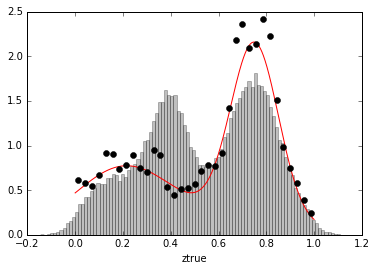

In [97]:
#written by David W. Hogg
"""
Code to take non-trivial p(z|d) data and infer dN/dz..
"""
import numpy as np
import scipy.optimize as op

trueamps = np.array([0.20, 0.35, 0.55])
trueamps /= np.sum(trueamps)
cumamps = np.cumsum(trueamps)
truemeans = np.array([0.5, 0.2, 0.75])
truesigmas = np.array([0.4, 0.2, 0.1])

def make_one_ztrue():
    ztrue = -1.
    while ztrue < 0. or ztrue > 1.:
        r = np.random.uniform(0., cumamps[-1])
        c = 0
        for k in range(1, len(cumamps)):
            if r > cumamps[k-1]:
                c = k
        ztrue = truemeans[c] + truesigmas[c] * np.random.normal()
    return ztrue

def sample_true_prior(N):
    print("Making ztrue values...")
    ztrues = np.array([make_one_ztrue() for n in range(N)])
    return ztrues

def evaluate_true_prior(zs):
    """
    Doesn't return properly normalized fuunction.
    """
    ps = np.zeros_like(zs)
    for c in range(len(trueamps)):
        ps += trueamps[c] / (np.sqrt(2. * np.pi) * truesigmas[c]) * \
            np.exp(-0.5 * (zs - truemeans[c]) ** 2 / truesigmas[c] ** 2)
    ps[zs < 0.] = 0.
    ps[zs > 1.] = 0.
    return ps

true_lf_sigma = 0.05
true_lf_outlier_fraction = 0.2
true_lf_outlier_mean = 0.4
true_lf_outlier_sigma = 0.075

def sample_likelihood(ztrue):
    if np.random.uniform() < true_lf_outlier_fraction:
        return true_lf_outlier_mean + true_lf_outlier_sigma * np.random.normal()
    return ztrue + true_lf_sigma * np.random.normal()

def evaluate_likelihood(zobs, ztrues):
    """
    assumes zobs is a scalar and ztrues is a vector.
    """
    ps = np.zeros_like(ztrues)
    ps += true_lf_outlier_fraction / (np.sqrt(2. * np.pi) * true_lf_outlier_sigma) * \
        np.exp(-0.5 * (zobs - true_lf_outlier_mean) ** 2 / true_lf_outlier_sigma ** 2)
    ps += (1. - true_lf_outlier_fraction) / (np.sqrt(2. * np.pi) * true_lf_sigma) * \
        np.exp(-0.5 * (zobs - ztrues) ** 2 / true_lf_sigma ** 2)
    return ps

def evaluate_interim_prior(ztrues):
    ps = np.ones_like(ztrues)
    ps[ztrues < 0.] = 0.
    ps[ztrues > 1.] = 0.
    return ps

K = 35#16
binfactor = 16#16
KK = K * binfactor # number of fine bins
dzfine = 1. / KK
zfine = np.arange(0.5 * dzfine, 1.0, dzfine)
interimfine = evaluate_interim_prior(zfine)
dzcoarse = 1. / K
zcoarse = np.arange(0.5 * dzcoarse, 1.0, dzcoarse)
interim = evaluate_interim_prior(zcoarse)

def get_binned_interim_posterior(zobs):
    """
    stupidly slow, but only called once.
    """
    ps = interimfine * evaluate_likelihood(zobs, zfine)
    ps /= np.sum(ps) * dzfine
    coarseps = np.array([np.sum(ps[k * binfactor : (k + 1) * binfactor]) * dzfine for k in range(K)])
    return coarseps / dzcoarse

def get_rectangular_data(zobss):
    ps = np.zeros((len(zobss), K))
    for n,zobs in enumerate(zobss):
        ps[n] = get_binned_interim_posterior(zobs)
    return ps

def hyper_lfs(data, lnamps):
    amps = np.exp(lnamps - np.max(lnamps))
    amps /= np.sum(amps)
    return np.sum(amps[None,:] * data / interim[None,:], axis=1)

def hyper_lnlf(data, lnamps):
    return np.sum(np.log(hyper_lfs(data, lnamps)))

prior_var = np.eye(K)
for k in range(K):
    prior_var[k] = 1. * np.exp(-0.5 * (zcoarse[k] - zcoarse) ** 2 / 0.05 ** 2)
print(prior_var)
prior_ivar = np.linalg.inv(prior_var)
print('prior_ivar shape='+str(np.shape(prior_ivar)))

def hyper_lnprior(lnamps):
    """
    Stupid Gaussian prior.
    """
    out = -0.5 * np.dot(np.dot(prior_ivar, lnamps), lnamps)
    #print('lnprior='+str(out))
    return out

def hyper_lnposterior(lnamps, data):
    out = hyper_lnprior(lnamps) + hyper_lnlf(data, lnamps)
    #print('lnposterior='+str(out))
    return out

def optimize_lnposterior(data):
    def _objective(pars, data):
        return -2. * hyper_lnposterior(pars, data)
    guess = np.sum(data, axis=0)
    guess /= np.sum(guess) * dzcoarse
    guess = np.log(guess)
    print("starting at", guess, _objective(guess, data))
    res = op.minimize(_objective, guess, args=(data, ), method="Nelder-Mead",
                      options={"maxfev": 1e5, "maxiter":1e4})
    print(res)
    return res

if __name__ == "__main__":
    import matplotlib.pylab as plt
    np.random.seed(42)
    N = 2 ** 16

    ztrues = sample_true_prior(N)
    nplot = 1000
    zplot = np.arange(0.5 / nplot, 1.0, 1.0 / nplot)
    plt.clf()
    plt.hist(ztrues, bins=100, normed=True, color="k")
    plt.plot(zplot, evaluate_true_prior(zplot), "r-")
    plt.xlabel("ztrue")
    plt.savefig("ztrues.png")

    zobss = np.array([sample_likelihood(ztrue) for ztrue in ztrues])
    data = get_rectangular_data(zobss)
    plt.clf()
    plt.plot(ztrues, zobss, "k.", alpha=0.5)
    plt.xlabel("ztrue")
    plt.ylabel("zobs")
    plt.savefig("scatter.png")

    plt.clf()
    plt.hist(zobss, bins=100, normed=True, color="k")
    plt.plot(zplot, evaluate_true_prior(zplot), "r-")
    plt.plot(zcoarse, np.sum(data, axis=0) / N, "go")
    plt.xlabel("z")
    plt.savefig("zobs.png")

    for n,zobs in enumerate(zobss[:10]):
        plt.clf()
        plt.plot(zplot, evaluate_likelihood(zobs, zplot), "k-")
        plt.plot(zcoarse, get_binned_interim_posterior(zobs), "ko")
        plt.axvline(zobs, color="k")
        plt.xlabel("ztrue")
        plt.xlim(0., 1.)
        plt.title("likelihood function for object {}".format(n))
        plt.savefig("lf_{:02d}.png".format(n))

    guess = np.log(evaluate_true_prior(zcoarse))
    print("hyperposterior at truth:", hyper_lnposterior(guess, data))
    guess = np.log(interim)
    print('guess shape='+str(np.shape(guess))+' with guess='+str(guess))
    print("hyperposterior at interim prior:", hyper_lnposterior(guess, data))
    res = optimize_lnposterior(data)
    map = np.exp(res.x)
    map /= np.sum(map) * dzcoarse

    plt.clf()
    plt.hist(zobss, bins=100, normed=True, color="k", alpha=0.25)
    plt.plot(zplot, evaluate_true_prior(zplot), "r-")
    plt.plot(zcoarse, map, "ko")
    plt.xlabel("ztrue")
    plt.savefig("map.png")


In [ ]:
#try posterior predictive p-values?